# **Motivation**

The motivation for this notebook is to create an accurate multiple input model that considers patient metadata and ECG curves in detecting heart disease. This model offers tremendous potential for detecting early signs of pulmonary issues.

In [ ]:
!pip install wfdb

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d khyeh0719/ptb-xl-dataset


ptb-xl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import wfdb
import os
import ast

In [ ]:
os.makedirs('/kaggle/working/data')
os.makedirs('/kaggle/working/logs')
os.makedirs('/kaggle/working/model')

FileExistsError: [Errno 17] File exists: '/kaggle/working/data'

In [ ]:
!unzip /content/ptb-xl-dataset.zip

Archive:  /content/ptb-xl-dataset.zip
replace ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Loading the Data**

Loading data as proposed by authors of PTB-XL ECG dataset.

In [ ]:
path = 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
ecg_data = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

scp_data = pd.read_csv(path + 'scp_statements.csv', index_col=0)
scp_data = scp_data[scp_data.diagnostic == 1]

In [ ]:
def load_signals(df, path):
    data = [wfdb.rdsamp(os.path.join(path, link)) for link in df.filename_lr]
    data = np.array([signal for signal, meta in data])
    return data

ecg_signal = load_signals(ecg_data, path)

In [ ]:
ecg_data['scp_codes'] = ecg_data['scp_codes'].apply(lambda x: ast.literal_eval(x))

In [ ]:
def superclasses(scp):
    res = set()
    for k in scp.keys():
        if k in scp_data.index:
            res.add(scp_data.loc[k].diagnostic_class)

    return list(res)

ecg_data['scp_classes'] = ecg_data['scp_codes'].apply(superclasses)

<font size="32">**Data Preprocessing**</font>

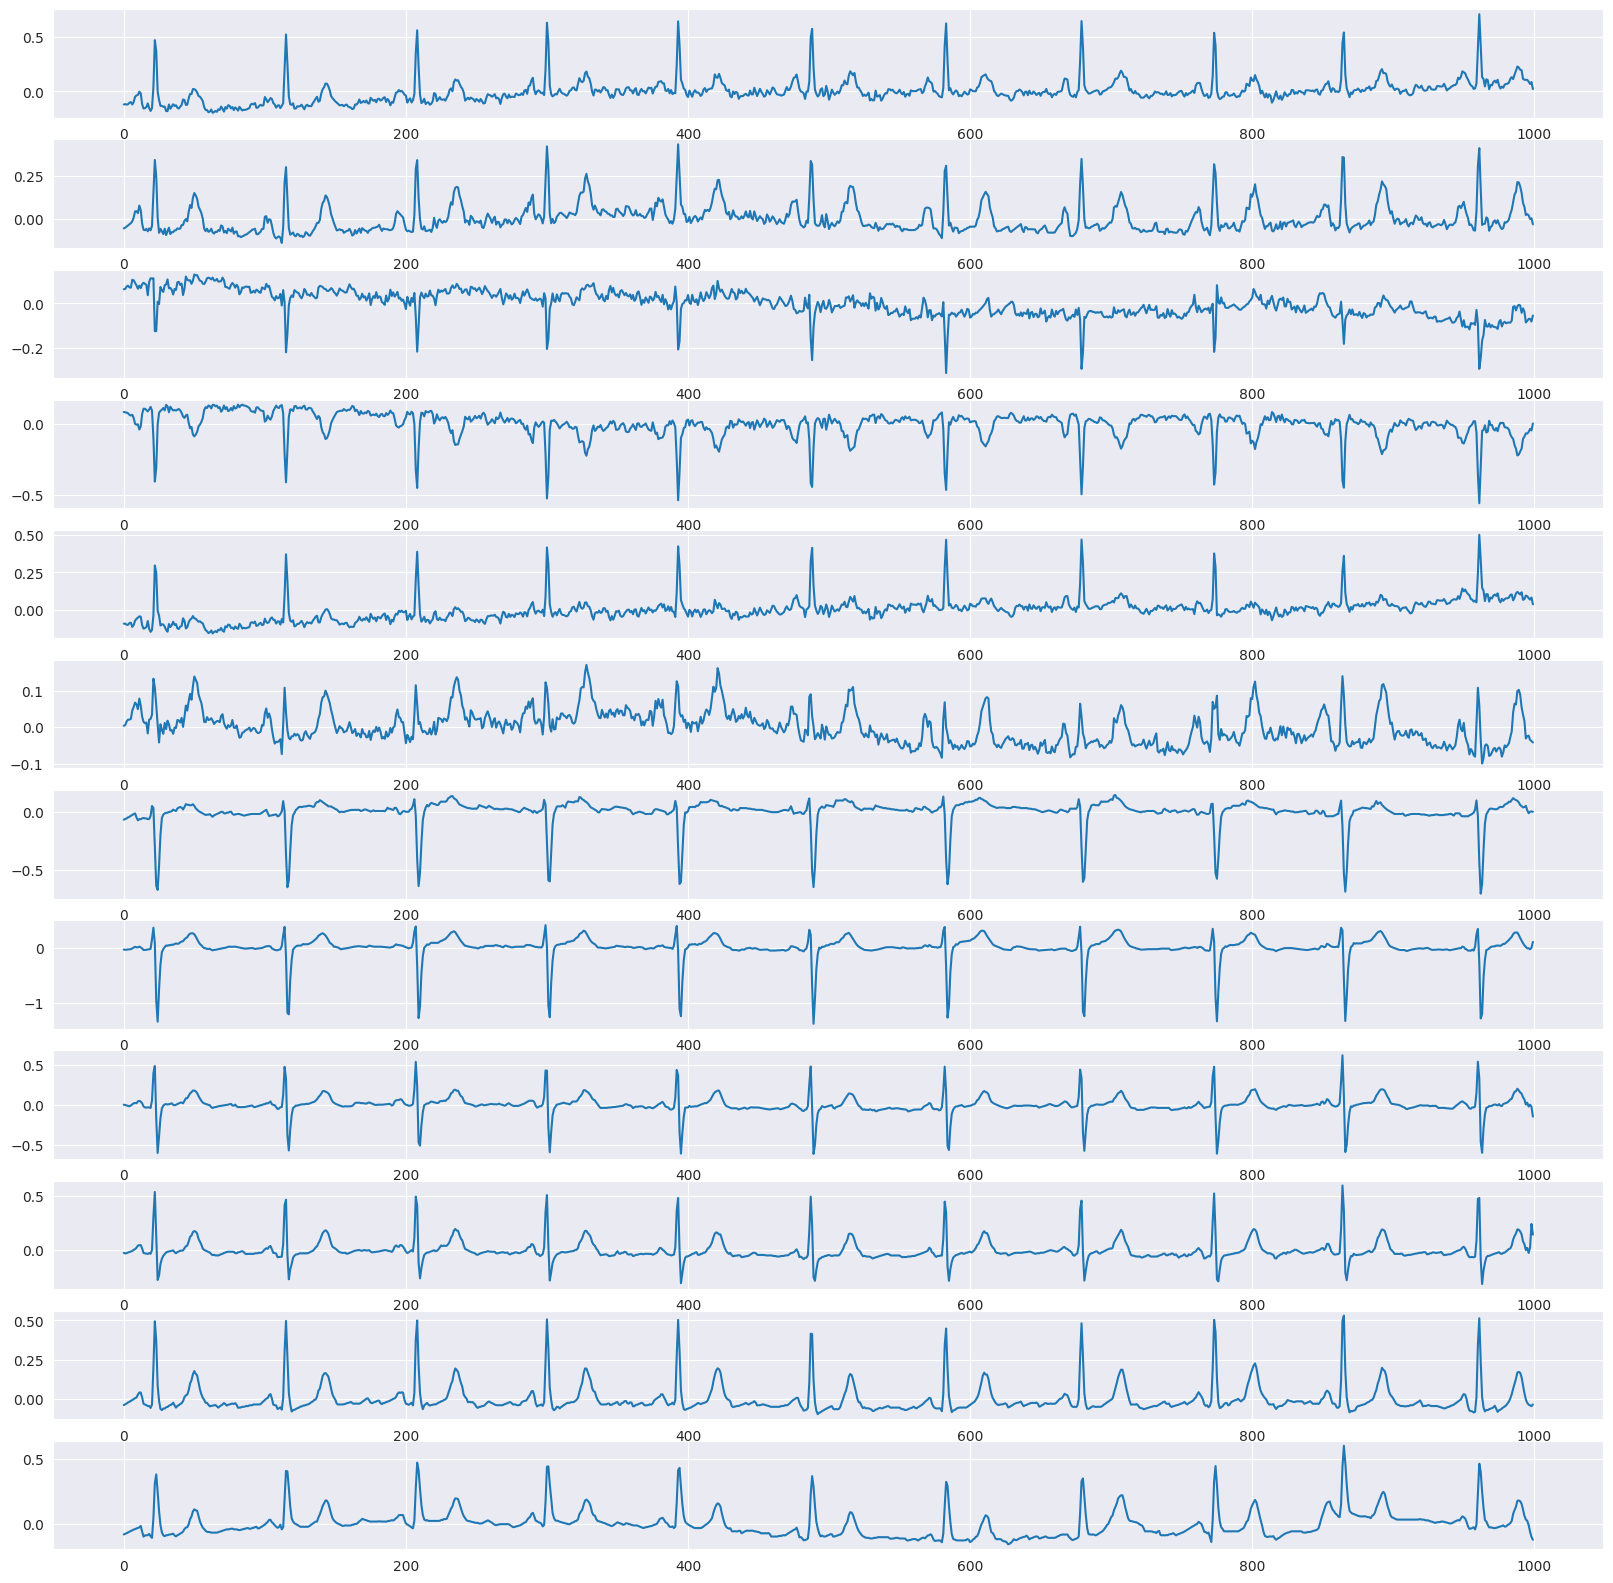

In [ ]:
# understanding the signal data

sns.set_style("darkgrid")

sample = ecg_signal[0]
sample.shape
fix, axes = plt.subplots(sample.shape[1], 1, figsize=(20,20))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
plt.show()

In [ ]:
# number of different values
ecg_data[[col for col in ecg_data.columns if col not in ('scp_codes', 'scp_classes')]].nunique(dropna=True)

patient_id                      18885
age                                94
sex                                 2
height                             77
weight                            127
nurse                              12
site                               51
device                             11
recording_date                  21813
report                           9883
heart_axis                          8
infarction_stadium1                 6
infarction_stadium2                 3
validated_by                       12
second_opinion                      2
initial_autogenerated_report        2
validated_by_human                  2
baseline_drift                    321
static_noise                      124
burst_noise                       103
electrodes_problems                14
extra_beats                       128
pacemaker                           4
strat_fold                         10
filename_lr                     21837
filename_hr                     21837
dtype: int64

In [ ]:
# number of null values
ecg_data.isnull().sum()

patient_id                          0
age                                89
sex                                 0
height                          14854
weight                          12408
nurse                            1509
site                               18
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8505
infarction_stadium1             16211
infarction_stadium2             21734
validated_by                     9411
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20230
static_noise                    18575
burst_noise                     21224
electrodes_problems             21807
extra_beats                     19883
pacemaker                       21544
strat_fold                          0
filename_lr                         0
filename_hr 

In [ ]:
ecg_data

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,scp_classes
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[STTC]


In [ ]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21837 entries, 1 to 21837
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21837 non-null  float64
 1   age                           21748 non-null  float64
 2   sex                           21837 non-null  int64  
 3   height                        6983 non-null   float64
 4   weight                        9429 non-null   float64
 5   nurse                         20328 non-null  float64
 6   site                          21819 non-null  float64
 7   device                        21837 non-null  object 
 8   recording_date                21837 non-null  object 
 9   report                        21837 non-null  object 
 10  scp_codes                     21837 non-null  object 
 11  heart_axis                    13332 non-null  object 
 12  infarction_stadium1           5626 non-null   object 
 13  i

Here, I reduce the number of features, focusing only on features with a direct correlation to pulmonary condition, storing them in **X**

In [ ]:
X = pd.DataFrame(index=ecg_data.index)

X['sex'] = ecg_data['sex']

X['height'] = ecg_data.groupby('sex')['height'].transform(lambda x: x.fillna(x.mean()))

X['weight'] = ecg_data.groupby('sex')['weight'].transform(lambda x: x.fillna(x.mean()))

X['infarction_stadium1'] = ecg_data['infarction_stadium1'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium I-II': 2,
    'Stadium II': 3,
    'Stadium II-III': 4,
    'Stadium III': 5
}).fillna(0)

X['infarction_stadium2'] = ecg_data['infarction_stadium2'].replace({
    'unknown': 0,
    'Stadium I': 1,
    'Stadium II': 2,
    'Stadium III': 3
}).fillna(0)

# 0 represents unknown
X['heart_axis'] = ecg_data.heart_axis.replace({
    'LAD': 1,
    'ALAD': 2,
    'RAD': 3,
    'AXR': 4,
    'MID': 5,
    'ARAD': 6,
    'AXL': 7,
    'SAG': 8
}).fillna(0)

X['pacemaker'] = (ecg_data.pacemaker == 'ja, pacemaker').astype(float)

# X represents meta data
X

,sex,height,weight,infarction_stadium1,infarction_stadium2,heart_axis,pacemaker
ecg_id,,,,,,,
1,1,160.987860,63.000000,0.0,0.0,0.0,0.0
2,0,173.494364,70.000000,0.0,0.0,0.0,0.0
3,1,160.987860,69.000000,0.0,0.0,0.0,0.0
4,0,173.494364,82.000000,0.0,0.0,0.0,0.0
5,1,160.987860,70.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
21833,1,160.987860,64.556847,0.0,0.0,1.0,0.0
21834,0,173.494364,78.504823,4.0,0.0,5.0,0.0
21835,1,160.987860,64.556847,0.0,0.0,5.0,0.0


In [ ]:
# Y variable for signal
Y = ecg_signal

**Z** is the target dataset. This model will use multilabel binary classification due to the possibility of multiple superclass annotations.

In [ ]:
Z = pd.DataFrame(0, index=ecg_data.index, columns=['NORM', 'MI', 'STTC', 'CD', 'HYP'], dtype='int')

for i in Z.index:
    for j in ecg_data.loc[i, 'scp_classes']:
        Z.loc[i, j] = 1

Z['NORM'] = Z['NORM'].fillna(0)

In [ ]:
# finished target data
Z

,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21833,0,0,1,0,0
21834,1,0,0,0,0
21835,0,0,1,0,0


# **Splitting the data**

I will use the recommended **strat_folds** suggested by the authors of the PTB-XL Dataset.

In [ ]:
# Training data
X_train = X[ecg_data.strat_fold <= 8]
Y_train = Y[ecg_data[ecg_data.strat_fold <= 8].index - 1]
Z_train = Z[ecg_data.strat_fold <= 8]

In [ ]:
# Cross Valuation Data
X_val = X[ecg_data.strat_fold == 9]
Y_val = Y[ecg_data[ecg_data.strat_fold == 9].index - 1]
Z_val = Z[ecg_data.strat_fold == 9]

In [ ]:
# Test data
X_test = X[ecg_data.strat_fold == 10]
Y_test = Y[ecg_data[ecg_data.strat_fold == 10].index - 1]
Z_test = Z[ecg_data.strat_fold == 10]

In [ ]:
# ensure shapes match
print(f'X_train: {X_train.shape} Y_train: {Y_train.shape} Z_train: {Z_train.shape}')
print(f'X_val: {X_val.shape} Y_val: {Y_val.shape} Z_val: {Z_val.shape}')
print(f'X_test: {X_test.shape} Y_test: {Y_test.shape} Z_test: {Z_test.shape}')

X_train: (17441, 7) Y_train: (17441, 1000, 12) Z_train: (17441, 5)
X_val: (2193, 7) Y_val: (2193, 1000, 12) Z_val: (2193, 5)
X_test: (2203, 7) Y_test: (2203, 1000, 12) Z_test: (2203, 5)


# **Scaling the data**

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Scaling X
X_scaler = StandardScaler()
X_scaler.fit(X_train)

X_train_scaled = pd.DataFrame(X_scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
# Scaling Y
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train.reshape(-1, Y_train.shape[-1]))

Y_train_scaled = Y_scaler.transform(Y_train.reshape(-1, Y_train.shape[-1])).reshape(Y_train.shape)
Y_val_scaled = Y_scaler.transform(Y_val.reshape(-1, Y_val.shape[-1])).reshape(Y_val.shape)
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1, Y_test.shape[-1])).reshape(Y_test.shape)

In [ ]:
X_train_scaled

,sex,height,weight,infarction_stadium1,infarction_stadium2,heart_axis,pacemaker
ecg_id,,,,,,,
1,1.044988,-0.815161,-0.762997,-0.320229,-0.066347,-0.979556,-0.115346
2,-0.956949,0.746306,-0.155879,-0.320229,-0.066347,-0.979556,-0.115346
3,1.044988,-0.815161,-0.242610,-0.320229,-0.066347,-0.979556,-0.115346
4,-0.956949,0.746306,0.884894,-0.320229,-0.066347,-0.979556,-0.115346
5,1.044988,-0.815161,-0.155879,-0.320229,-0.066347,-0.979556,-0.115346
...,...,...,...,...,...,...,...
21832,-0.956949,0.746306,0.581753,-0.320229,-0.066347,-0.537835,-0.115346
21833,1.044988,-0.815161,-0.627970,-0.320229,-0.066347,-0.537835,-0.115346
21834,-0.956949,0.746306,0.581753,2.777877,-0.066347,1.229048,-0.115346


In [ ]:
Y_train_scaled

array([[[-7.03528036e-01, -3.25834014e-01,  3.68218369e-01, ...,
         -8.25981359e-02, -1.39793650e-01, -2.73257521e-01],
        [-6.85481717e-01, -3.01474998e-01,  3.74021769e-01, ...,
         -9.93567618e-02, -1.21492015e-01, -2.55420710e-01],
        [-7.09543476e-01, -2.58846719e-01,  4.37859165e-01, ...,
         -8.93015863e-02, -1.03190379e-01, -2.37583898e-01],
        ...,
        [ 4.27374661e-01,  9.10246099e-03, -4.03633789e-01, ...,
          8.49881226e-02, -1.47114304e-01, -1.98342911e-01],
        [ 5.29637138e-01,  3.34614773e-02, -4.73274585e-01, ...,
          8.15664210e-01, -1.65415939e-01, -3.41037407e-01],
        [ 1.44648986e-01, -1.79679916e-01, -3.16582794e-01, ...,
          4.83843418e-01, -1.25152342e-01, -4.19519379e-01]],

       [[ 3.63710685e-02,  8.49488525e-01,  7.74456347e-01, ...,
          6.48077951e-01,  3.06766252e-01,  3.22491997e-01],
        [-1.07999489e-01,  7.15513935e-01,  7.86063146e-01, ...,
          5.27415845e-01,  2.11597748e

# **Saving the data**

To avoid having to reprocess the data each time, I will save the data using **Joblib**. This will be helpful down the road.

In [ ]:
import joblib
import os

In [ ]:
joblib.dump(X_train_scaled, '/kaggle/working/data/X_train_scaled.joblib')
joblib.dump(Y_train_scaled, '/kaggle/working/data/Y_train_scaled.joblib')
joblib.dump(Z_train, '/kaggle/working/data/Z_train.joblib')
joblib.dump(X_test_scaled, '/kaggle/working/data/X_test_scaled.joblib')
joblib.dump(Y_test_scaled, '/kaggle/working/data/Y_test_scaled.joblib')
joblib.dump(Z_test, '/kaggle/working/data/Z_test.joblib')
joblib.dump(X_val_scaled, '/kaggle/working/data/X_val_scaled.joblib')
joblib.dump(Y_val_scaled, '/kaggle/working/data/Y_val_scaled.joblib')
joblib.dump(Z_val, '/kaggle/working/data/Z_val.joblib')

['/kaggle/working/data/Z_val.joblib']

<font size="32">**Building the Model**</font>

This model will utilize Keras functional API to create a multi-input model applying a 1D Convolutional Neural Network for the patient signal data and fully connected layers for patient meta data. In theory, this model will be able to provide a more encompassing and accurate prediction.

In [ ]:
import tensorflow as tf
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Concatenate, GlobalAveragePooling1D, BatchNormalization, ReLU
import joblib
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

sns.set_style('darkgrid')

In [ ]:
# loading the saved data
# loading the saved data
X_train_scaled = joblib.load('/kaggle/working/data/X_train_scaled.joblib')
Z_train = joblib.load('/kaggle/working/data/Z_train.joblib')
X_val_scaled = joblib.load('/kaggle/working/data/X_val_scaled.joblib')
Z_val = joblib.load('/kaggle/working/data/Z_val.joblib')

# **Meta Data Classifier**

This first model will utilize patient meta data (**X** dataset).

It will be composed of five fully connected Dense layers along with Dropout layers to prevent overfitting. The final layer will have a sigmoid activation for binary classification of different pulmonary conditions.

In [ ]:
# Define input layer
X_input = tf.keras.layers.Input(X_train_scaled.shape[1:], name="X_input")

# Define dense layers
X = Dense(128, activation='relu', name="X_dense_1")(X_input)
X = Dropout(0.4, name="X_dropout_1")(X)
X = Dense(128, activation='relu', name="X_dense_2")(X)
X = Dropout(0.4, name="X_dropout_2")(X)
X = Dense(64, activation='relu', name="X_dense_3")(X)
X = Dropout(0.4, name="X_dropout_3")(X)
X = Dense(32, activation='relu', name="X_dense_4")(X)

# Output layer with sigmoid activation for binary classification
outputX = Dense(1, activation='sigmoid', name="X_dense_5")(X)

# Define the model
modelX = tf.keras.Model(inputs=X_input, outputs=outputX)

Running the metadata model alone gives me a binary accuracy of approximately 80%

In [ ]:
# Compile the model
modelX.compile(
    loss='binary_crossentropy',  # Use binary cross-entropy for binary classification
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Train the model
modelX.fit(
    X_train_scaled, Z_train['MI'],  # Assuming 'MI' is the column for myocardial infarction
    epochs=40, batch_size=32,
    validation_data=(X_val_scaled, Z_val['MI'])  # Assuming 'MI' is the column for myocardial infarction
)

Epoch 1/40
546/546 [==============================] - 6s 4ms/step - loss: 0.4444 - accuracy: 0.8289 - precision: 0.9455 - recall: 0.3397 - val_loss: 0.4251 - val_accuracy: 0.8413 - val_precision: 0.9537 - val_recall: 0.3787
Epoch 2/40
546/546 [==============================] - 3s 5ms/step - loss: 0.4202 - accuracy: 0.8372 - precision: 0.9428 - recall: 0.3757 - val_loss: 0.4226 - val_accuracy: 0.8422 - val_precision: 0.9541 - val_recall: 0.3824
Epoch 3/40
546/546 [==============================] - 2s 3ms/step - loss: 0.4132 - accuracy: 0.8368 - precision: 0.9137 - recall: 0.3882 - val_loss: 0.4153 - val_accuracy: 0.8422 - val_precision: 0.9541 - val_recall: 0.3824
Epoch 4/40
546/546 [==============================] - 2s 3ms/step - loss: 0.4117 - accuracy: 0.8395 - precision: 0.9242 - recall: 0.3944 - val_loss: 0.4154 - val_accuracy: 0.8422 - val_precision: 0.9541 - val_recall: 0.3824
Epoch 5/40
546/546 [==============================] - 2s 3ms/step - loss: 0.4111 - accuracy: 0.8379 - pr

# **Signal Classifier**

This second model will use a 1D CNN with GlobalAveragePooling rather than a fully connected layer to reduce potential overfitting and maintain the relation between the CNN's feature maps and categories.

Batch normalization will be used before each activation to improve model stability and avoid an internal covariate shift. Finally, Max Pooling will be used after each activation to reduce computational complexity and identify distinctive signal features.

Also, increasing the number of filters increases the number of abstractions the CNN is able to potentially extract

In [ ]:
# Y model
Y_input = tf.keras.layers.Input(Y_train_scaled.shape[1:], name="Y_input")

Y = Conv1D(32, 3, padding='same', name="Y_conv_1")(Y_input)
Y = BatchNormalization(name="Y_norm_1")(Y)
Y = ReLU(name="Y_relu_1")(Y)
Y = MaxPooling1D(2, name="Y_max_1")(Y)

Y = Conv1D(64, 3, padding='same', name="Y_conv_2")(Y)
Y = BatchNormalization(name="Y_norm_2")(Y)
Y = ReLU(name="Y_relu_2")(Y)
Y = MaxPooling1D(2, name="Y_max_2")(Y)

Y = Conv1D(128, 3, padding='same', name="Y_conv_3")(Y)
Y = BatchNormalization(name="Y_norm_3")(Y)
Y = ReLU(name="Y_relu_3")(Y)

Y = GlobalAveragePooling1D(name="Y_global")(Y)

outputY = Dropout(0.4, name="Y_dropout")(Y)


# **Encompassing Model**

This model will concatenate the previous metadata and signal data to provide a more encompassing model.

In [ ]:
Z = Concatenate(name="Z_concat")([outputX, outputY])
Z = Dense(64, activation='relu', name="Z_dense_1")(Z)
Z = Dropout(0.4, name="Z_dropout_1")(Z)
Z = Dense(64, activation='relu', name="Z_dense_2")(Z)
Z = Dropout(0.4, name="Z_dropout_2")(Z)
output = Dense(Z_train.shape[-1], activation="sigmoid", name="Z_dense_3")(Z)

modelZ = tf.keras.Model(inputs=[X_input, Y_input], outputs=output)

We will utilize the Adam optimizer to improve the learning rate algorithm along with logarithmic loss for binary classification.

In [ ]:
modelZ.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy', 'Precision', 'Recall']
)

modelZ.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Y_input (InputLayer)        [(None, 1000, 12)]           0         []                            
                                                                                                  
 Y_conv_1 (Conv1D)           (None, 1000, 32)             1184      ['Y_input[0][0]']             
                                                                                                  
 Y_norm_1 (BatchNormalizati  (None, 1000, 32)             128       ['Y_conv_1[0][0]']            
 on)                                                                                              
                                                                                                  
 Y_relu_1 (ReLU)             (None, 1000, 32)             0         ['Y_norm_1[0][0]']      

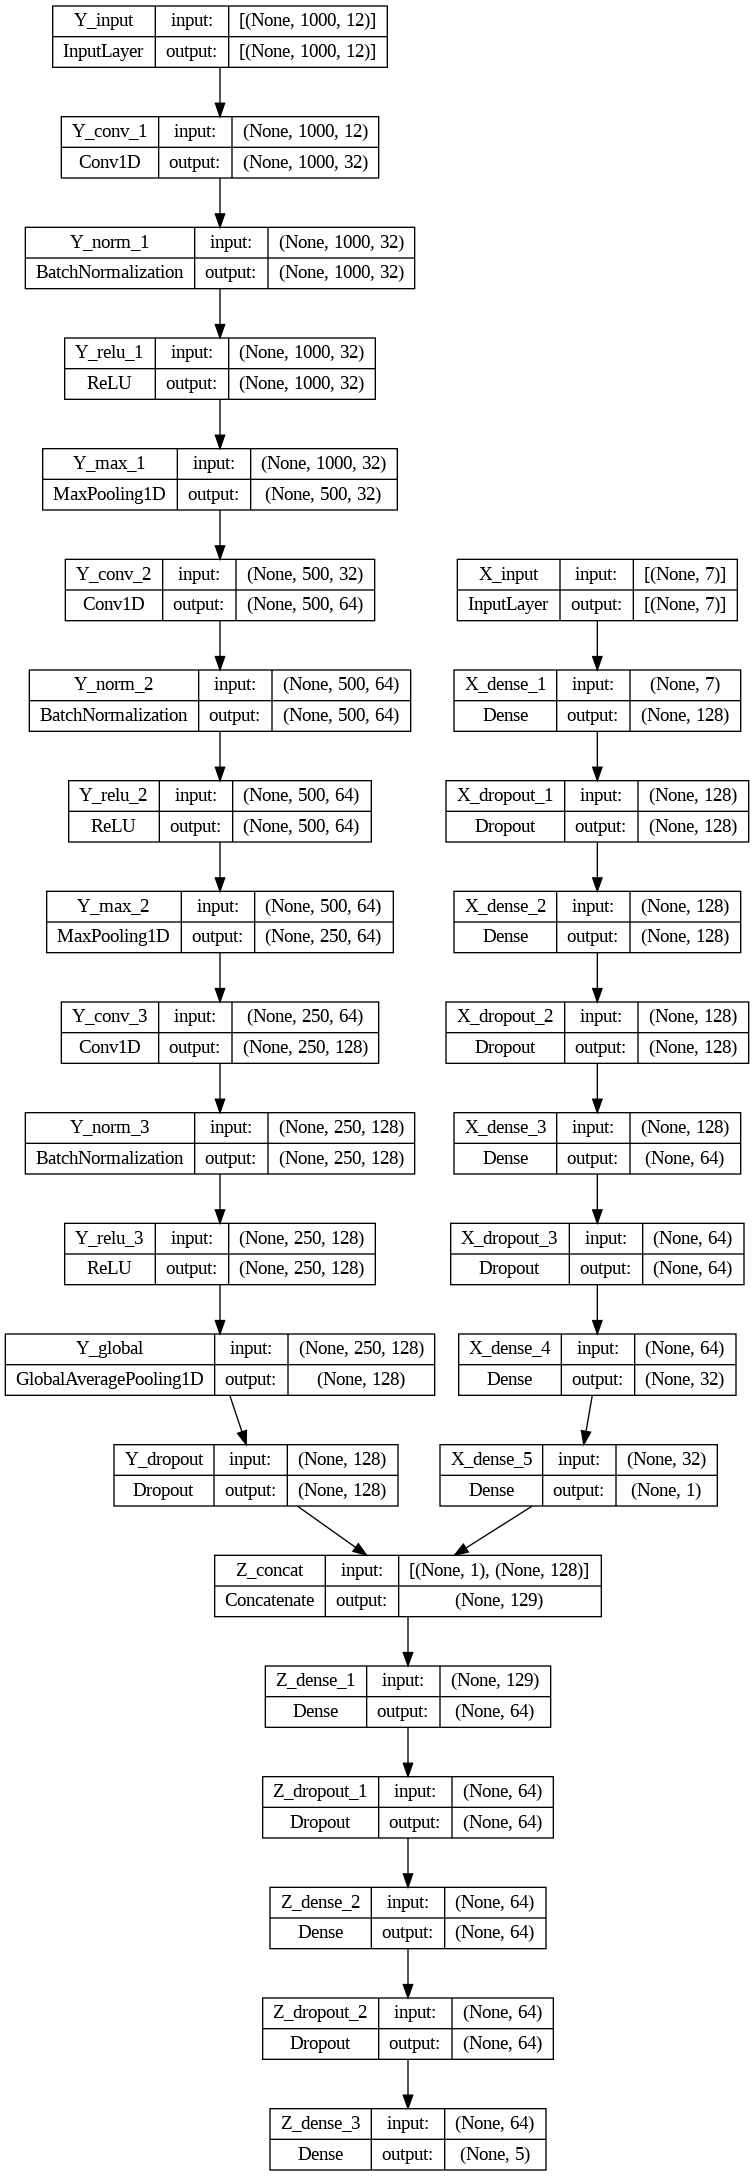

In [ ]:
# displaying the model to better understand its process
tf.keras.utils.plot_model(modelZ, show_shapes=True)

Early stopping will help prevent overfitting of the model and ModelCheckpoint will allow us to save only the best model.

In [ ]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(monitor='val_binary_accuracy', save_best_only=True, filepath='/kaggle/working/model'),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', restore_best_weights=True, patience=10, min_delta=0.001),
    tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs')
]

fitting = modelZ.fit(
    [X_train_scaled, Y_train_scaled], Z_train, epochs=100, batch_size=32, callbacks=callback, validation_data=([X_val_scaled, Y_val_scaled], Z_val)
)

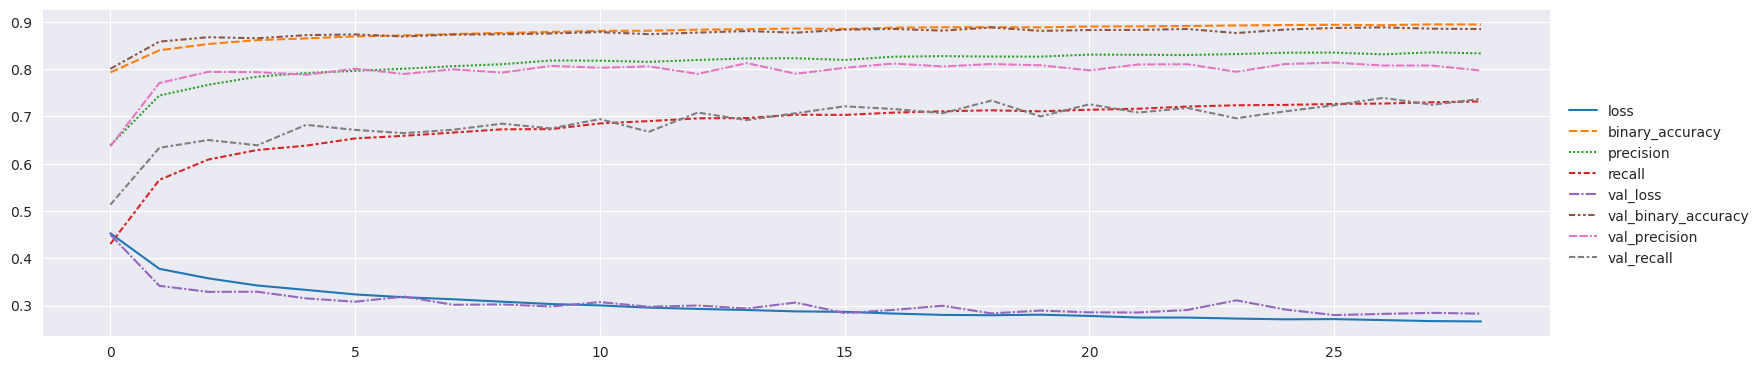

In [ ]:
sns.relplot(data=pd.DataFrame(fitting.history), kind='line', height=4, aspect=4)
plt.show()

In [ ]:
final_detection_model = tf.keras.models.load_model('/kaggle/working/model')

In [ ]:
final_detection_model.evaluate([X_test_scaled, Y_test_scaled], Z_test)

69/69 [==============================] - 1s 6ms/step - loss: 0.2778 - binary_accuracy: 0.8913 - precision: 0.8205 - recall: 0.7330


[0.2777554392814636,
 0.8913300037384033,
 0.8205435872077942,
 0.7329525351524353]

In [ ]:
import tensorflow as tf
import numpy as np
import time

# Define a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Generate a single random input example
input_data = np.random.rand(1, 784)

# Warm up both TensorFlow and TensorFlow Lite
model.predict(input_data)

# Measure inference time for TensorFlow
start_time_tf = time.time()
model.predict(input_data)
end_time_tf = time.time()
inference_time_tf = end_time_tf - start_time_tf
print("Inference time with TensorFlow:", inference_time_tf, "seconds")

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Measure inference time for TensorFlow Lite
start_time_tflite = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
end_time_tflite = time.time()
inference_time_tflite = end_time_tflite - start_time_tflite
print("Inference time with TensorFlow Lite:", inference_time_tflite, "seconds")


1/1 [==============================] - 0s 36ms/step
Inference time with TensorFlow: 0.13400816917419434 seconds
Inference time with TensorFlow Lite: 0.0006480216979980469 seconds


In [ ]:
import tensorflow as tf

# Define a simple model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Save the TensorFlow model
model.save("tensorflow_model")

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open("tensorflow_lite_model.tflite", "wb") as f:
    f.write(tflite_model)

# Measure the file sizes
tensorflow_model_size = os.path.getsize("tensorflow_model")
print("TensorFlow model size:", tensorflow_model_size, "bytes")

tensorflow_lite_model_size = os.path.getsize("tensorflow_lite_model.tflite")
print("TensorFlow Lite model size:", tensorflow_lite_model_size, "bytes")


TensorFlow model size: 4096 bytes
TensorFlow Lite model size: 408040 bytes


In [ ]:
from tabulate import tabulate
# Print the results in tabular format
table = [
    ["", "Size (bytes)", "Inference Time (seconds)"],
    ["TensorFlow", tensorflow_model_size, inference_time_tf],
    ["TensorFlow Lite", tensorflow_lite_model_size, inference_time_tflite]
]

print(tabulate(table, headers="firstrow", tablefmt="grid"))

+-----------------+----------------+----------------------------+
|                 |   Size (bytes) |   Inference Time (seconds) |
+=================+================+============================+
| TensorFlow      |           4096 |                0.134008    |
+-----------------+----------------+----------------------------+
| TensorFlow Lite |         408040 |                0.000648022 |
+-----------------+----------------+----------------------------+


# **Conclusion**

Using this model, I achieved an **89% binary accuracy** for detecting pulmonary issues.

Other things I have tried:
* Changing Dropout parameters to reduce variance and overfitting
* Applying a fully connected layer rather than Global Average Pooling
* Changing number and order of layers
* Changing number of neurons in each layer